# Explainable Lipids

In [1]:
from dataclasses import dataclass, field
import math
from pathlib import Path
import time
from typing import Callable, Union, Iterable

from lightning import pytorch as pl
import numpy as np
import pandas as pd
from rdkit import Chem
import torch

from chemprop import data, featurizers, models
from chemprop.models import MPNN

In [2]:
def make_prediction(
    models: list[MPNN],
    trainer: pl.Trainer,
    smiles: list[str],
) -> np.ndarray:
    """Makes predictions on a list of SMILES.

    Parameters
    ----------
    models : list
        A list of models to make predictions with.
    smiles : list
        A list of SMILES to make predictions on.

    Returns
    -------
    list[list[float]]
        A list of lists containing the predicted values.
    """

    test_data = [data.MoleculeDatapoint.from_smi(smi) for smi in smiles]
    test_dset = data.MoleculeDataset(test_data)
    test_loader = data.build_dataloader(
        test_dset, batch_size=1, num_workers=0, shuffle=False
    )

    with torch.inference_mode():
        sum_preds = []
        for model in models:
            predss = trainer.predict(model, test_loader)
            preds = torch.cat(predss, 0)
            preds = preds.cpu().numpy()
            sum_preds.append(preds)

        # Ensemble predictions
        sum_preds = sum(sum_preds)
        avg_preds = sum_preds / len(models)

    return avg_preds

In [3]:
@dataclass
class MCTSNode:
    """Represents a node in a Monte Carlo Tree Search.

    Parameters
    ----------
    smiles : str
        The SMILES for the substructure at this node.
    atoms : list
        A list of atom indices in the substructure at this node.
    W : float
        The total action value, which indicates how likely the deletion will lead to a good rationale.
    N : int
        The visit count, which indicates how many times this node has been visited. It is used to balance exploration and exploitation.
    P : float
        The predicted property score of the new subgraphs' after the deletion, shown as R in the original paper.
    """

    smiles: str
    atoms: Iterable[int]
    W: float = 0
    N: int = 0
    P: float = 0
    children: list[...] = field(default_factory=list)

    def __post_init__(self):
        self.atoms = set(self.atoms)

    def Q(self) -> float:
        """
        Returns
        -------
        float
            The mean action value of the node.
        """
        return self.W / self.N if self.N > 0 else 0

    def U(self, n: int, c_puct: float = 10.0) -> float:
        """
        Parameters
        ----------
        n : int
            The sum of the visit count of this node's siblings.
        c_puct : float
            A constant that controls the level of exploration.

        Returns
        -------
        float
            The exploration value of the node.
        """
        return c_puct * self.P * math.sqrt(n) / (1 + self.N)

In [4]:
def find_clusters(mol: Chem.Mol) -> tuple[list[tuple[int, ...]], list[list[int]]]:
    """Finds clusters within the molecule. Jin et al. from [1]_ only allows deletion of one peripheral non-aromatic bond or one peripheral ring from each state,
    so the clusters here are defined as non-ring bonds and the smallest set of smallest rings.

    Parameters
    ----------
    mol : RDKit molecule
        The molecule to find clusters in.

    Returns
    -------
    tuple
        A tuple containing:
        - list of tuples: Each tuple contains atoms in a cluster.
        - list of int: Each atom's cluster index.

    References
    ----------
    .. [1] Jin, Wengong, Regina Barzilay, and Tommi Jaakkola. "Multi-objective molecule generation using interpretable substructures." International conference on machine learning. PMLR, 2020. https://arxiv.org/abs/2002.03244
    """

    n_atoms = mol.GetNumAtoms()
    if n_atoms == 1:  # special case
        return [(0,)], [[0]]

    clusters = []
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        if not bond.IsInRing():
            clusters.append((a1, a2))

    ssr = [tuple(x) for x in Chem.GetSymmSSSR(mol)]
    clusters.extend(ssr)

    atom_cls = [[] for _ in range(n_atoms)]
    for i in range(len(clusters)):
        for atom in clusters[i]:
            atom_cls[atom].append(i)

    return clusters, atom_cls

In [5]:
def extract_subgraph_from_mol(mol: Chem.Mol, selected_atoms: set[int]) -> tuple[Chem.Mol, list[int]]:
    """Extracts a subgraph from an RDKit molecule given a set of atom indices.

    Parameters
    ----------
    mol : RDKit molecule
        The molecule from which to extract a subgraph.
    selected_atoms : list of int
        The indices of atoms which form the subgraph to be extracted.

    Returns
    -------
    tuple
        A tuple containing:
        - RDKit molecule: The subgraph.
        - list of int: Root atom indices from the selected indices.
    """

    selected_atoms = set(selected_atoms)
    roots = []
    for idx in selected_atoms:
        atom = mol.GetAtomWithIdx(idx)
        bad_neis = [y for y in atom.GetNeighbors() if y.GetIdx() not in selected_atoms]
        if len(bad_neis) > 0:
            roots.append(idx)

    new_mol = Chem.RWMol(mol)

    for atom_idx in roots:
        atom = new_mol.GetAtomWithIdx(atom_idx)
        atom.SetAtomMapNum(1)
        aroma_bonds = [
            bond for bond in atom.GetBonds() if bond.GetBondType() == Chem.rdchem.BondType.AROMATIC
        ]
        aroma_bonds = [
            bond
            for bond in aroma_bonds
            if bond.GetBeginAtom().GetIdx() in selected_atoms
            and bond.GetEndAtom().GetIdx() in selected_atoms
        ]
        if len(aroma_bonds) == 0:
            atom.SetIsAromatic(False)

    remove_atoms = [
        atom.GetIdx() for atom in new_mol.GetAtoms() if atom.GetIdx() not in selected_atoms
    ]
    remove_atoms = sorted(remove_atoms, reverse=True)
    for atom in remove_atoms:
        new_mol.RemoveAtom(atom)

    return new_mol.GetMol(), roots

In [6]:
def extract_subgraph(smiles: str, selected_atoms: set[int]) -> tuple[str, list[int]]:
    """Extracts a subgraph from a SMILES given a set of atom indices.

    Parameters
    ----------
    smiles : str
        The SMILES string from which to extract a subgraph.
    selected_atoms : list of int
        The indices of atoms which form the subgraph to be extracted.

    Returns
    -------
    tuple
        A tuple containing:
        - str: SMILES representing the subgraph.
        - list of int: Root atom indices from the selected indices.
    """
    # try with kekulization
    mol = Chem.MolFromSmiles(smiles)
    Chem.Kekulize(mol)
    subgraph, roots = extract_subgraph_from_mol(mol, selected_atoms)
    try:
        subgraph = Chem.MolToSmiles(subgraph, kekuleSmiles=True)
        subgraph = Chem.MolFromSmiles(subgraph)
    except Exception:
        subgraph = None

    mol = Chem.MolFromSmiles(smiles)  # de-kekulize
    if subgraph is not None and mol.HasSubstructMatch(subgraph):
        return Chem.MolToSmiles(subgraph), roots

    # If fails, try without kekulization
    subgraph, roots = extract_subgraph_from_mol(mol, selected_atoms)
    subgraph = Chem.MolToSmiles(subgraph)
    subgraph = Chem.MolFromSmiles(subgraph)

    if subgraph is not None:
        return Chem.MolToSmiles(subgraph), roots
    else:
        return None, None

In [7]:
def mcts_rollout(
    node: MCTSNode,
    state_map: dict[str, MCTSNode],
    orig_smiles: str,
    clusters: list[set[int]],
    atom_cls: list[set[int]],
    nei_cls: list[set[int]],
    scoring_function: Callable[[list[str]], list[float]],
    min_atoms: int = 15,
    c_puct: float = 10.0,
) -> float:
    """A Monte Carlo Tree Search rollout from a given MCTSNode.

    Parameters
    ----------
    node : MCTSNode
        The MCTSNode from which to begin the rollout.
    state_map : dict
        A mapping from SMILES to MCTSNode.
    orig_smiles : str
        The original SMILES of the molecule.
    clusters : list
        Clusters of atoms.
    atom_cls : list
        Atom indices in the clusters.
    nei_cls : list
        Neighboring cluster indices.
    scoring_function : function
        A function for scoring subgraph SMILES using a Chemprop model.
    min_atoms : int
        The minimum number of atoms in a subgraph.
    c_puct : float
        The constant controlling the level of exploration.

    Returns
    -------
    float
        The score of this MCTS rollout.
    """
    # Return if the number of atoms is less than the minimum
    cur_atoms = node.atoms
    if len(cur_atoms) <= min_atoms:
        return node.P

    # Expand if this node has never been visited
    if len(node.children) == 0:
        # Cluster indices whose all atoms are present in current subgraph
        cur_cls = set([i for i, x in enumerate(clusters) if x <= cur_atoms])

        for i in cur_cls:
            # Leaf atoms are atoms that are only involved in one cluster.
            leaf_atoms = [a for a in clusters[i] if len(atom_cls[a] & cur_cls) == 1]

            # This checks
            # 1. If there is only one neighbor cluster in the current subgraph (so that we don't produce unconnected graphs), or
            # 2. If the cluster has only two atoms and the current subgraph has only one leaf atom.
            # If either of the conditions is met, remove the leaf atoms in the current cluster.
            if len(nei_cls[i] & cur_cls) == 1 or len(clusters[i]) == 2 and len(leaf_atoms) == 1:
                new_atoms = cur_atoms - set(leaf_atoms)
                new_smiles, _ = extract_subgraph(orig_smiles, new_atoms)
                if new_smiles in state_map:
                    new_node = state_map[new_smiles]  # merge identical states
                else:
                    new_node = MCTSNode(new_smiles, new_atoms)
                if new_smiles:
                    node.children.append(new_node)

        state_map[node.smiles] = node
        if len(node.children) == 0:
            return node.P  # cannot find leaves

        scores = scoring_function([x.smiles for x in node.children])
        for child, score in zip(node.children, scores):
            child.P = score

    sum_count = sum(c.N for c in node.children)
    selected_node = max(node.children, key=lambda x: x.Q() + x.U(sum_count, c_puct=c_puct))
    v = mcts_rollout(
        selected_node,
        state_map,
        orig_smiles,
        clusters,
        atom_cls,
        nei_cls,
        scoring_function,
        min_atoms=min_atoms,
        c_puct=c_puct,
    )
    selected_node.W += v
    selected_node.N += 1

    return v

In [8]:
def mcts(
    smiles: str,
    scoring_function: Callable[[list[str]], list[float]],
    n_rollout: int,
    max_atoms: int,
    prop_delta: float,
    min_atoms: int = 15,
    c_puct: int = 10,
) -> list[MCTSNode]:
    """Runs the Monte Carlo Tree Search algorithm.

    Parameters
    ----------
    smiles : str
        The SMILES of the molecule to perform the search on.
    scoring_function : function
        A function for scoring subgraph SMILES using a Chemprop model.
    n_rollout : int
        The number of MCTS rollouts to perform.
    max_atoms : int
        The maximum number of atoms allowed in an extracted rationale.
    prop_delta : float
        The minimum required property value for a satisfactory rationale.
    min_atoms : int
        The minimum number of atoms in a subgraph.
    c_puct : float
        The constant controlling the level of exploration.

    Returns
    -------
    list
        A list of rationales each represented by a MCTSNode.
    """

    mol = Chem.MolFromSmiles(smiles)

    clusters, atom_cls = find_clusters(mol)
    nei_cls = [0] * len(clusters)
    for i, cls in enumerate(clusters):
        nei_cls[i] = [nei for atom in cls for nei in atom_cls[atom]]
        nei_cls[i] = set(nei_cls[i]) - {i}
        clusters[i] = set(list(cls))
    for a in range(len(atom_cls)):
        atom_cls[a] = set(atom_cls[a])

    root = MCTSNode(smiles, set(range(mol.GetNumAtoms())))
    state_map = {smiles: root}
    for _ in range(n_rollout):
        mcts_rollout(
            root,
            state_map,
            smiles,
            clusters,
            atom_cls,
            nei_cls,
            scoring_function,
            min_atoms=min_atoms,
            c_puct=c_puct,
        )

    rationales = [
        node
        for _, node in state_map.items()
        if len(node.atoms) <= max_atoms and node.P >= prop_delta
    ]

    return rationales

In [9]:
mpnn = models.MPNN.load_from_checkpoint('sum_regression_chem/sum_regression_chem_d4_h1800_n3_p0.1_e200_r1/best-epoch=34-val_loss=0.48.ckpt')
mpnn

MPNN(
  (message_passing): BondMessagePassing(
    (W_i): Linear(in_features=86, out_features=2048, bias=False)
    (W_h): Linear(in_features=2048, out_features=2048, bias=False)
    (W_o): Linear(in_features=2120, out_features=2048, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (tau): ReLU()
    (V_d_transform): Identity()
    (graph_transform): Identity()
  )
  (agg): SumAggregation()
  (bn): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=2048, out_features=1800, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.1, inplace=False)
        (2): Linear(in_features=1800, out_features=1800, bias=True)
      )
      (2): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.1, inplace=False)
        (2): Linear(in_features=1800, out_features=1800, bias=True)
      )
      (3): Sequential(
        (0): R

In [10]:
chemprop_dir = Path.cwd()
test_path = chemprop_dir / "test2.csv"
smiles_column = "SMILES"

In [11]:
df_test = pd.read_csv(test_path)[['SMILES','Predicted']]
df_test

,SMILES,Predicted
0,OCCN(CCCCCC(OCCCCCCCCCCC)=O)CCCCCCCC(OC(CCCCCC...,1.471826
1,O=C(CCCCCCCN(CCO)CCCCCCCC(OC(CCC(CCCC(C)C)C)CC...,1.413179
2,CCCCCCCCC(OC(CCCCCCC[N+]1(CCCC1)CCCCCCCC(OC(CC...,1.346587
3,CCCCCCCCC(CCCCCCCC)OC(CCCCCCCOP(OCCCCCCCC(OC(C...,1.304467
4,O=C(CCN(CCCCCCO)CCC(OCCCCOC(C(CCCCCCCC)CCCCCCC...,1.298505
5,CCCCCCCCC(OC(CCCCCCCOP(OCCCNC1=C2C(N=CN2)=NC=N...,1.287949
6,CC(C)CCC[C@@H](C)[C@H]1CC[C@@]2([H])[C@]3([H])...,1.178772
7,O=C(OCC)C1=C(C(OCC)=O)N(CCCN(CCCCCCCC)CCCCCCCC...,1.150689
8,CCCCCCCCC(CCCCCCCC)OC(CCCCCCCOP(OCCCCCCCC(OC(C...,1.081311


In [12]:
trainer = pl.Trainer(logger=None, enable_progress_bar=True, accelerator="auto", devices=[0])

/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/akshay/apps/miniconda3/envs/chemprop/lib/pytho ...
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `C

In [13]:
# MCTS options
rollout = 10  # number of MCTS rollouts to perform. If mol.GetNumAtoms() > 50, consider setting n_rollout = 1 to avoid long computation time

c_puct = 10.0  # constant that controls the level of exploration

max_atoms = 20  # maximum number of atoms allowed in an extracted rationale

min_atoms = 8  # minimum number of atoms in an extracted rationale

prop_delta = 0.5  # Minimum score to count as positive.
# In this algorithm, if the predicted property from the substructure if larger than prop_delta, the substructure is considered satisfactory.
# This value depends on the property you want to interpret. 0.5 is a dummy value for demonstration purposes

num_rationales_to_keep = 3  # number of rationales to keep for each molecule

In [14]:
# Define the scoring function. "Score" for a substructure is the predicted property value of the substructure.

models = [mpnn]

property_for_interpretation = "Predicted"

property_id = (
    df_test.columns.get_loc(property_for_interpretation) - 1
)  # property index in the dataset; -1 for the SMILES column


def scoring_function(smiles: list[str]) -> list[float]:
    return make_prediction(
        models=models,
        trainer=trainer,
        smiles=smiles,
    )[:, property_id]

In [15]:
all_smiles = df_test[smiles_column].tolist()[:3]
all_smiles

['OCCN(CCCCCC(OCCCCCCCCCCC)=O)CCCCCCCC(OC(CCCCCCCC)CCCCCCCC)=O',
 'O=C(CCCCCCCN(CCO)CCCCCCCC(OC(CCC(CCCC(C)C)C)CCC(CCCC(C)C)C)=O)OC(CCC(CCCC(C)C)C)CCC(CCCC(C)C)C',
 'CCCCCCCCC(OC(CCCCCCC[N+]1(CCCC1)CCCCCCCC(OC(CCCCCCCC)CCCCCCCC)=O)=O)CCCCCCCC.[Cl-]']

In [16]:
df_test.columns.get_loc(property_for_interpretation)

1

In [17]:
%%time

results_df = {"smiles": [], property_for_interpretation: []}

for i in range(num_rationales_to_keep):
    results_df[f"rationale_{i}"] = []
    results_df[f"rationale_{i}_score"] = []

for smiles in all_smiles:
    score = scoring_function([smiles])[0]
    if score > prop_delta:
        rationales = mcts(
            smiles=smiles,
            scoring_function=scoring_function,
            n_rollout=rollout,
            max_atoms=max_atoms,
            prop_delta=prop_delta,
            min_atoms=min_atoms,
            c_puct=c_puct,
        )
    else:
        rationales = []

    results_df["smiles"].append(smiles)
    results_df[property_for_interpretation].append(score)

    if len(rationales) == 0:
        for i in range(num_rationales_to_keep):
            results_df[f"rationale_{i}"].append(None)
            results_df[f"rationale_{i}_score"].append(None)
    else:
        min_size = min(len(x.atoms) for x in rationales)
        min_rationales = [x for x in rationales if len(x.atoms) == min_size]
        rats = sorted(min_rationales, key=lambda x: x.P, reverse=True)

        for i in range(num_rationales_to_keep):
            if i < len(rats):
                results_df[f"rationale_{i}"].append(rats[i].smiles)
                results_df[f"rationale_{i}_score"].append(rats[i].P)
            else:
                results_df[f"rationale_{i}"].append(None)
                results_df[f"rationale_{i}_score"].append(None)

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/core/saving.py:363: Skipping 'metrics' parameter because it is not possible to safely dump to YAML.
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 222.96it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 236.62it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 235.63it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 233.82it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 236.97it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 236.08it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 241.82it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 241.24it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 243.34it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 236.74it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 242.19it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 242.51it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 244.92it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 158.82it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 250.75it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 237.65it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 242.04it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 243.00it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 236.96it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 242.87it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 241.42it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 246.56it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 250.72it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 250.25it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 246.38it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 238.04it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 222.47it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 219.71it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 236.18it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 236.98it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 243.19it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 228.67it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 233.29it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 247.10it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 254.35it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 260.03it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 252.28it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 266.74it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 248.39it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 236.51it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 245.65it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 250.61it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 238.15it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 239.67it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 238.05it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 229.04it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 242.19it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 227.60it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 240.03it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 230.99it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 238.71it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 239.61it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 240.50it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 243.34it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 235.85it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 242.59it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 244.21it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 248.66it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 238.61it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 245.40it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 251.54it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 239.93it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 237.93it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 244.02it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 236.45it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 234.01it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 230.68it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 218.84it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 222.10it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 229.90it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 249.07it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 246.88it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 232.36it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 259.26it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 261.59it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 253.46it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 262.66it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 267.38it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 258.45it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 257.73it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 251.99it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 244.57it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 246.72it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 240.35it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 235.67it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 234.59it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 239.83it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 239.24it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 237.67it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 234.13it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 248.17it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 245.03it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 238.13it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 241.48it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 234.17it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 246.26it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 248.10it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 250.00it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 237.81it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 243.29it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 242.76it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 252.77it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 242.96it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 245.09it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 242.64it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 246.09it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 240.53it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 228.37it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 213.67it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 209.56it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 218.79it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 245.54it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 244.98it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 233.99it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 260.43it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 256.98it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 259.90it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 257.10it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 266.66it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 258.10it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 270.19it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 243.02it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 245.81it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 237.89it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 236.41it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 236.87it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 235.14it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 231.65it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 240.32it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 232.29it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 247.17it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 256.34it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 230.85it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 243.96it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 251.65it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 250.95it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 245.76it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 248.93it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 249.77it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 244.09it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 263.05it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 265.33it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 262.27it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 272.79it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 263.62it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 260.26it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 271.85it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 239.08it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 240.14it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 234.43it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 230.76it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 230.14it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 177.59it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 234.29it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 239.21it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 238.74it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 236.66it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 239.07it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 240.89it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 243.97it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 247.83it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 248.56it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 248.04it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 246.01it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 245.86it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 252.21it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 24.67it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 253.76it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 254.03it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 244.75it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 251.74it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 238.01it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 228.97it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 221.07it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 239.80it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 247.80it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 258.50it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 237.73it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 253.99it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 269.95it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 269.44it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 271.98it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 265.32it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 279.94it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 264.63it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 257.79it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 239.75it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 241.89it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 238.69it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 233.23it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 237.70it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 229.67it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 239.51it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 241.83it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 239.57it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 186.41it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 237.59it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 232.37it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 234.80it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 236.91it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 244.27it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 230.10it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 233.82it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 248.07it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 247.13it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 236.04it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 246.86it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 247.46it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 247.57it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 238.05it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 219.14it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 224.07it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 233.84it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 239.86it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 247.22it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 236.79it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 260.41it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 260.47it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 266.01it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 273.17it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 247.68it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 265.80it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 252.90it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 238.77it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 251.68it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 259.01it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 230.81it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 232.26it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 236.60it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 236.52it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 231.82it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 232.18it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 238.43it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 231.17it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 128.76it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 236.89it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 239.31it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 241.66it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 239.45it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 247.79it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 17.77it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 240.02it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 246.88it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 242.64it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 246.06it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 255.99it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 245.53it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 240.43it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 229.64it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 221.43it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 213.74it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 233.61it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 237.77it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 241.99it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 235.01it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 18.00it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 262.93it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 268.62it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 269.26it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 266.11it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 244.68it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 259.28it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 232.43it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 241.12it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 230.06it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 241.31it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 233.65it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 238.16it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 234.98it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 238.79it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 229.82it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 239.47it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 233.78it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 242.50it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 241.09it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 246.38it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 242.13it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 244.74it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 241.64it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 247.30it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 252.49it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 119.79it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 239.20it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 241.77it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 233.91it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 222.31it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 221.14it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 229.36it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 238.13it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 245.91it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 234.75it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 252.01it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 265.41it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 268.06it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 260.41it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 272.51it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 273.59it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 257.25it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 247.56it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 233.28it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 240.44it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 240.45it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 243.35it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 239.08it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 242.65it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 245.19it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 244.01it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 243.05it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 249.14it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 243.30it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 245.27it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 250.56it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 245.87it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 249.65it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 244.92it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 17.33it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 252.76it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 242.49it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 239.91it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 233.93it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 220.53it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 219.60it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 239.61it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 250.24it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 250.85it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 234.45it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 259.63it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 263.27it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 262.57it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 270.60it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 266.68it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 263.11it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 237.78it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 238.66it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 244.59it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 247.62it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 241.12it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 234.53it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 247.48it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 238.67it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 247.49it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 251.92it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 249.47it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 243.29it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 246.24it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 249.22it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 247.50it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 247.52it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 250.45it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 244.21it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 245.18it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 246.25it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 247.11it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 245.74it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 237.05it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 215.88it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 216.40it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 233.16it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 246.63it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 242.05it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 231.60it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 255.86it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 261.18it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 257.26it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 266.09it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 252.05it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 257.88it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 258.77it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 261.78it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 250.61it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 191.28it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 15/15 [00:00<00:00, 225.78it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 224.46it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 225.39it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 228.74it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 232.27it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 230.25it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 229.88it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 234.08it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 232.34it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 236.81it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 222.34it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 236.37it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 237.88it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 240.09it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 236.73it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 238.83it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 243.89it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 240.66it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 240.93it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 240.38it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 240.11it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 248.26it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 244.50it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 243.05it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 247.70it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 233.39it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 222.95it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 197.73it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 230.46it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 241.14it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 248.89it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 229.75it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 257.76it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 256.71it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 255.82it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 267.28it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 256.23it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 260.85it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 264.28it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 259.78it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 261.47it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 268.04it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 234.22it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 266.49it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 277.39it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 271.20it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 269.17it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 267.02it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 263.46it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 272.45it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 268.17it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 266.91it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 258.73it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 267.15it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 260.10it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 268.48it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 261.86it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 272.29it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 226.18it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 229.51it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 228.51it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 229.22it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 227.06it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 231.38it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 238.43it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 230.37it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 230.10it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 238.89it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 233.94it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 235.75it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 237.54it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 243.74it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 241.41it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 244.87it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 219.90it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 237.62it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 246.10it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 245.74it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 244.41it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 243.24it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 238.54it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 244.19it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 228.33it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 217.76it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 197.83it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 237.72it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 238.01it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 242.24it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 232.39it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 255.83it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 258.24it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 256.60it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 258.95it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 261.19it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 260.93it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 257.83it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 270.22it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 257.34it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 270.41it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 265.86it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 262.81it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 268.38it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 265.29it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 266.11it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 261.40it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 258.56it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 263.93it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 267.29it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 254.07it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 262.37it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 252.59it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 180.30it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 247.28it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 255.05it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 229.76it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 229.78it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 230.14it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 230.06it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 230.80it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 233.60it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 237.39it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 229.37it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 233.97it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 235.98it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 235.06it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 238.70it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 240.55it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 207.73it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 241.22it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 235.56it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 239.23it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 238.67it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 236.60it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 244.79it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 247.18it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 243.30it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 241.43it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 238.96it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 229.54it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 217.69it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 196.57it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 223.70it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 233.99it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 232.55it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 229.01it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 247.43it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 246.95it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 255.29it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 249.09it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 249.25it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 257.39it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 248.30it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 254.81it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 254.53it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 256.76it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 256.93it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 262.63it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 262.19it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 266.08it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 265.61it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 268.03it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 260.17it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 261.69it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 258.66it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 258.39it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 265.01it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 254.95it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 231.83it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 254.81it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 252.05it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 258.08it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 229.71it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 233.74it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 222.34it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 233.11it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 234.57it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 230.89it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 238.31it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 234.18it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 231.63it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 233.91it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 237.97it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 242.22it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 235.79it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 241.13it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 243.36it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 240.87it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 240.95it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 237.32it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 243.96it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 238.16it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 241.92it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 243.15it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 242.14it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 239.71it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 230.90it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 216.95it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 197.93it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 232.51it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 26.60it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 239.83it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 229.53it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 254.43it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 251.94it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 243.63it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 252.23it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 258.25it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 259.40it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 261.33it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 258.60it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 261.90it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 260.03it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 122.31it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 256.87it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 264.05it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 272.18it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 267.18it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 261.62it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 257.29it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 264.50it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 230.46it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 250.17it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 244.76it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 245.56it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 249.65it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 248.41it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 240.02it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 239.46it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 223.57it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 224.85it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 228.90it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 230.38it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 228.94it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 230.19it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 231.77it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 205.13it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 230.77it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 233.32it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 237.47it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 233.06it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 239.02it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 235.04it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 238.19it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 243.71it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 238.82it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 242.15it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 245.00it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 241.53it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 240.44it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 239.62it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 243.37it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 235.88it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 226.99it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 215.85it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 193.00it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 239.98it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 227.65it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 230.68it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 229.85it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 244.07it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 249.45it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 251.22it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 246.72it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 239.71it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 243.58it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 236.43it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 234.52it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 249.91it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 252.54it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 248.93it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 207.37it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 255.50it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 258.18it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 259.32it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 262.88it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 261.59it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 264.66it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 248.74it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 239.79it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 244.87it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 237.39it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 255.79it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 259.09it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 257.40it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 223.89it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 228.41it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 230.10it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 185.44it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 232.04it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 230.36it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 232.37it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 163.33it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 233.01it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 233.02it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 234.88it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 235.95it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 244.52it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 241.03it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 240.04it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 244.13it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 241.58it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 238.36it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 241.81it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 246.16it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 242.56it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 242.14it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 229.99it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 234.38it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 228.88it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 215.76it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 193.60it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 231.22it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 236.15it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 237.12it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 217.58it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 241.12it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 243.74it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 256.10it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 250.70it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 250.16it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 251.35it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 257.38it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 253.75it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 256.34it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 255.72it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 253.79it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 262.68it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 253.22it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 263.60it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 263.23it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 265.33it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 265.37it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 260.97it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 264.21it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 249.19it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 227.92it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 228.67it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 233.39it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 236.69it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 230.25it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 231.68it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 231.53it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 234.73it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 235.87it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 235.68it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 237.63it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 237.77it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 240.97it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 242.86it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 237.02it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 243.62it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 242.00it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 153.99it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 241.44it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 247.02it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 244.79it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 245.70it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 236.61it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 243.07it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 229.82it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 211.33it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 196.98it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 234.10it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 240.19it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 246.54it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 229.79it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 250.63it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 243.20it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 259.25it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 228.40it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 253.18it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 251.07it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 254.90it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 259.27it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 264.70it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 264.08it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 257.84it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 268.07it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 268.94it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 268.99it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 262.75it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 271.46it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 250.74it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 255.00it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 228.34it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 228.52it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 231.76it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 233.46it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 233.48it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 232.14it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 232.05it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 236.69it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 235.70it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 236.02it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 241.74it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 245.93it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 245.16it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 247.44it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 235.40it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 241.17it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 240.96it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 242.22it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 39.04it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 245.74it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 246.67it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 247.04it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 243.96it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 234.57it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 231.30it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 220.03it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 196.15it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 230.59it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 237.00it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 227.35it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 223.70it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 247.10it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 254.67it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 256.42it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 254.42it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 253.77it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 261.83it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 252.11it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 254.35it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 257.24it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 260.63it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 261.49it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 265.00it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 270.54it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 260.66it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 265.58it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 265.32it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 269.54it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 274.72it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 256.91it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 228.19it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 231.12it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 231.09it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 231.71it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 171.96it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 232.92it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 232.28it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 231.77it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 236.03it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 234.99it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 239.13it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 239.05it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 246.43it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 47.64it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 239.81it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 240.87it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 242.16it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 244.28it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 239.36it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 241.24it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 245.26it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 247.15it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 243.67it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 244.34it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 33.60it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 218.76it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 200.29it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 235.98it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 236.33it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 241.73it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 231.95it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 251.59it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 257.69it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 257.89it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 258.20it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 253.88it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 258.60it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 255.81it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 248.62it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 261.23it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 263.99it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 269.25it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 262.57it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 264.86it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 271.41it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 269.65it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 266.21it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 252.28it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 224.77it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 228.12it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 231.59it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 230.54it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 232.15it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 235.18it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 233.97it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 233.37it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 234.32it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 234.17it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 237.83it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 232.61it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 238.77it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 156.40it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 244.40it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 240.49it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 240.48it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 238.16it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 243.89it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 247.12it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 246.01it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 247.62it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 241.45it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 245.69it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 233.25it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 223.32it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 201.57it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 237.44it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 242.20it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 225.71it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 247.32it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 252.58it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 253.96it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 254.36it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 255.61it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 262.60it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 259.50it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 262.72it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 253.87it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 263.21it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 263.50it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 260.51it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 260.54it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 261.91it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 262.67it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 256.41it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 255.78it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 268.62it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 247.57it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 207.22it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 230.87it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 229.00it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 229.58it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 235.46it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 234.17it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 235.60it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 238.33it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 239.13it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 235.49it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 232.41it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 233.88it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 237.54it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 237.33it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 241.45it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 240.14it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 252.02it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 237.20it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 241.03it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 235.66it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 243.40it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 243.10it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 243.27it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 240.77it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 231.49it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 232.06it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 223.84it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 207.00it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 207.81it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 229.16it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 232.46it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 229.25it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 225.25it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 246.40it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 248.63it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 251.29it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 256.76it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 229.89it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 238.84it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 245.43it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 239.30it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 245.81it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 248.84it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 252.12it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 250.14it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 254.64it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 251.24it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 250.03it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 260.22it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 254.48it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 181.78it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 249.47it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 244.90it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 230.98it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 233.03it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 209.73it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 236.21it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 234.44it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 240.21it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 242.18it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 242.95it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 245.84it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 235.24it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 239.24it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 231.51it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 241.96it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 239.98it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 241.94it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 237.99it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 244.30it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 243.98it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 242.41it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 252.55it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 245.62it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 248.60it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 242.44it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 230.25it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 227.42it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 212.76it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 184.21it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 210.22it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 215.41it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 216.68it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 203.48it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 234.39it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 239.56it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 243.84it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 239.34it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 240.70it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 242.68it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 246.34it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 245.33it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 242.28it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 232.92it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 246.01it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 236.77it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 248.65it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 244.91it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 246.50it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 255.18it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 254.79it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 256.58it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 250.09it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 259.53it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 235.43it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 228.88it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 234.72it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 231.43it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 240.38it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 203.17it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 232.81it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 239.07it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 242.84it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 234.51it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 241.77it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 244.66it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 246.69it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 247.19it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 248.95it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 247.84it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 248.93it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 231.06it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 242.70it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 245.28it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 252.46it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 245.65it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 236.85it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 234.42it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 230.93it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 208.14it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 202.79it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 234.55it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 233.40it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 230.40it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 228.85it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 245.05it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 247.49it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 244.94it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 246.90it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 246.63it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 250.32it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 254.22it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 262.83it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 257.68it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 260.40it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 260.08it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 263.13it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 262.74it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 253.34it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 175.21it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 257.91it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 258.90it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 233.08it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 228.84it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 227.74it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 234.06it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 232.32it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 236.13it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 237.03it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 230.64it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 241.23it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 233.34it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 174.20it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 231.81it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 235.55it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 235.77it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 239.11it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 241.43it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 233.50it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 235.09it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 240.43it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 244.22it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 247.52it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 246.05it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 239.79it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 240.74it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 204.46it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 219.06it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 211.58it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 228.92it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 234.49it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 240.62it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 227.08it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 237.13it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 243.23it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 249.78it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 249.72it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 251.04it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 249.44it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 254.98it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 244.62it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 256.15it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 256.42it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 261.90it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 259.37it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 245.08it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 255.69it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 262.83it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 236.49it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 227.37it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 230.89it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 231.32it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 234.49it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 232.11it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 235.17it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 235.67it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 231.27it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 234.53it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 232.87it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 243.24it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 235.59it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 238.98it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 238.83it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 123.95it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 244.60it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 240.16it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 236.89it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 244.54it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 190.41it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 234.95it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 229.32it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 228.98it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 217.72it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 203.78it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 205.54it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 212.11it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 220.65it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 222.23it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 221.23it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 234.23it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 224.44it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 241.05it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 244.43it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 238.01it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 234.48it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 238.96it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 245.37it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 241.83it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 255.02it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 247.26it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 255.31it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 251.49it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 260.24it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 241.98it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 259.07it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 261.13it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 258.11it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 258.00it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 225.84it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 228.40it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 223.93it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 227.21it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 230.49it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 231.56it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 228.10it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 228.20it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 231.29it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 224.23it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 229.64it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 231.90it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 233.95it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 232.46it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 236.56it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 233.41it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 237.36it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 221.90it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 226.41it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 237.45it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 219.91it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 234.66it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 222.59it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 231.21it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 214.92it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 209.72it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 209.59it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 220.85it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 220.64it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 230.28it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 211.06it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 239.15it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 231.15it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 236.35it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 233.04it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 228.23it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 246.06it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 232.35it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 231.61it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 228.50it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 250.09it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 237.66it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 245.02it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 241.98it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 249.51it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 242.34it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 249.97it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 251.93it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 225.22it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 236.56it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 227.87it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 232.19it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 237.98it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 235.39it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 244.44it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 243.10it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 239.87it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 240.98it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 246.65it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 235.02it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 22.78it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 230.11it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 235.30it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 241.12it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 241.80it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 243.13it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 237.78it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 237.62it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 234.63it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 220.03it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 235.49it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 221.70it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 214.55it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 203.11it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 224.56it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 228.05it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 209.61it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 218.34it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 220.54it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 233.33it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 239.47it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 239.89it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 249.18it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 228.13it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 237.99it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 239.05it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 243.78it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 228.26it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 245.41it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 202.62it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 242.24it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 246.13it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 246.54it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 123.66it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 233.07it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 228.69it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 235.70it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 235.09it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 237.22it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 225.65it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 229.77it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 233.17it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 238.04it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 228.31it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 236.29it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 236.94it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 230.32it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 242.25it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 238.97it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 237.88it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 246.35it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 246.25it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 250.63it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 240.48it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 239.01it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 234.66it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 222.44it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 203.52it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 228.74it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 229.40it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 244.03it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 224.98it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 247.20it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 246.69it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 253.91it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 238.48it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 242.06it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 248.88it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 254.36it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 259.71it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 246.66it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 256.49it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 250.53it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 245.84it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 256.41it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 249.53it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 229.10it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 232.05it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 236.51it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 228.75it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 236.09it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 231.01it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 234.25it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 242.55it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 236.95it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 232.24it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 236.92it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 237.19it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 245.62it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 243.65it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 230.01it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 238.40it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 233.34it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 246.18it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 248.75it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 244.30it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 236.26it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 228.44it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 234.15it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 215.21it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 198.13it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 229.74it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 233.63it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 226.81it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 219.99it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 239.71it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 256.55it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 247.93it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 250.29it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 249.30it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 250.99it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 18.28it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 258.40it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 257.46it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 259.29it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 242.61it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 260.53it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 233.91it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 234.66it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 237.02it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 237.22it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 239.29it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 241.17it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 236.05it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 231.87it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 230.53it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 231.46it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 231.10it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 231.68it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 234.59it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 234.91it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 233.69it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 235.73it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 233.61it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 236.66it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 237.21it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 245.61it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 228.46it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 17.97it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 224.52it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 213.54it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 197.56it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 224.75it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 224.56it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 221.99it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 233.48it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 230.38it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 231.73it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 238.02it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 229.67it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 219.17it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 232.51it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 242.75it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 238.33it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 252.34it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 220.90it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 237.52it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 238.28it/s]
CPU times: user 1min 41s, sys: 11 s, total: 1min 52s
Wall time: 2min 1s


In [19]:
results_df = pd.DataFrame(results_df)
results_df
results_df.to_excel("mcts_results.xlsx", index=False)

# RDKit substructure

In [20]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

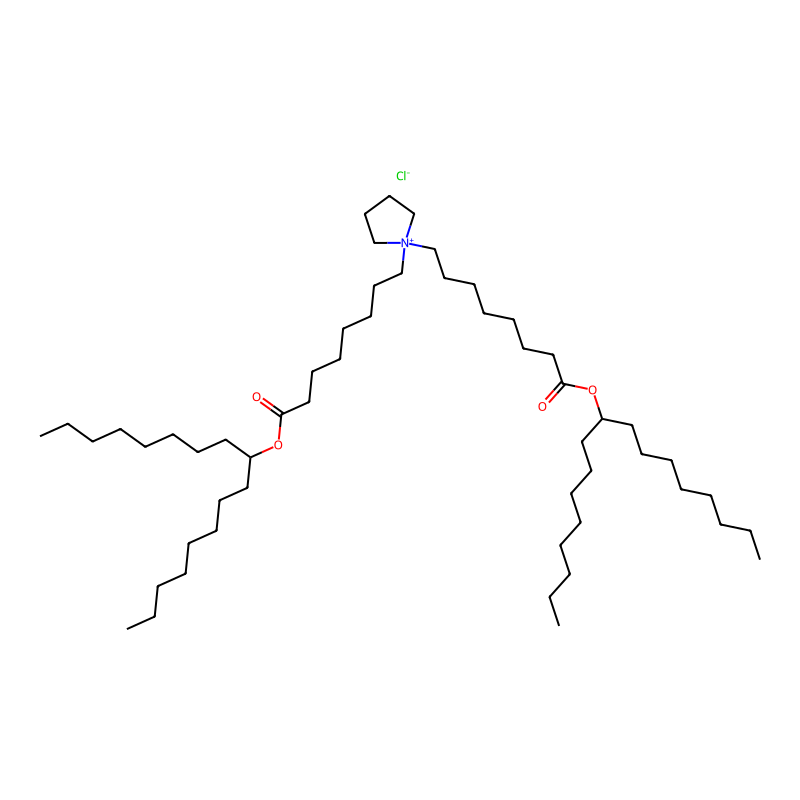

In [31]:
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = (800, 800)  # width, height in pixels
m = Chem.MolFromSmiles('CCCCCCCCC(OC(CCCCCCC[N+]1(CCCC1)CCCCCCCC(OC(CCCCCCCC)CCCCCCCC)=O)=O)CCCCCCCC.[Cl-]')
m

((15, 16, 17, 18, 19, 20, 21, 22, 59), (25, 24, 23, 18, 19, 20, 21, 22, 59))


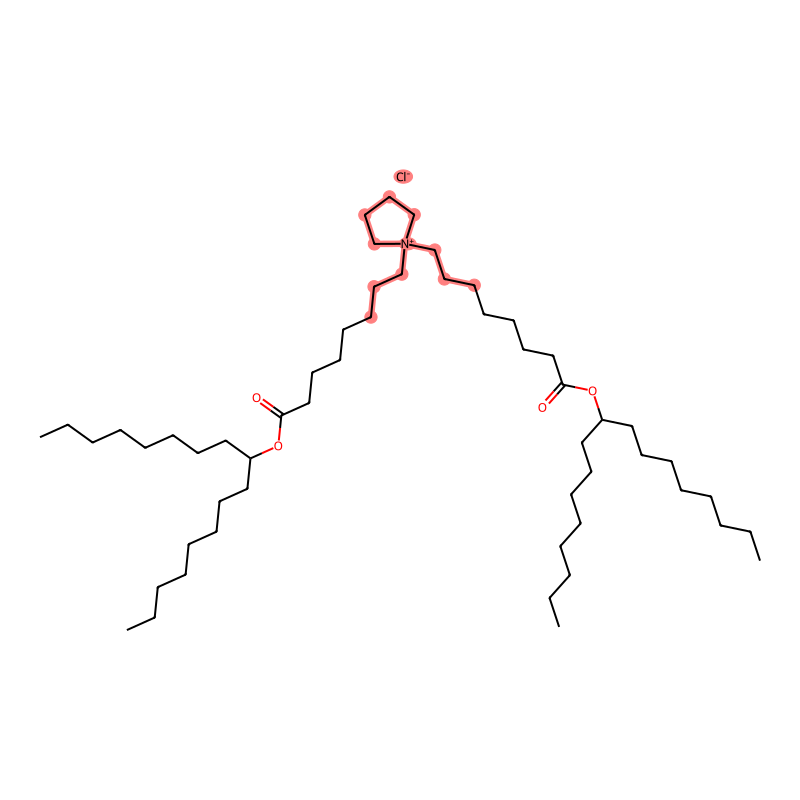

In [33]:
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = (800, 800)  # width, height in pixels
m = Chem.MolFromSmiles('CCCCCCCCC(OC(CCCCCCC[N+]1(CCCC1)CCCCCCCC(OC(CCCCCCCC)CCCCCCCC)=O)=O)CCCCCCCC.[Cl-]')
substructure = Chem.MolFromSmarts('CCC[N+]1(CCCC1).[Cl-]')
print(m.GetSubstructMatches(substructure))
m